# 04_Accessibility

#### Here we calculate and visualize  accessibilty

<div class="alert alert-block alert-info"><b>Accessibilty is an extremly complex metric because more than facilities and the environment; accessibilty is determined by the needs of the investigator. A pensioner has different needs to a single 20-something who has different needs to a nuclear-family of 4 with one child in primary school and another in secondary.</b></div>

> **Our investigation focuses on:**
  - **access to food ~ `supermarket`, `convenience` stores, `kiosk`, `greengrocer` and `marketplace`.**
  - **access to school ~ `kindergarten`, `primary`, `secondary`**
  - **access to low/no-cost local activites ~ `park`, `library` and `community_center`**
  - **access to health_care ~ `clinic` and `hospital`**
  - **the rest ~ `restaurant`, `cafe`, `cinema`, `theatre`, `atm`,  `bank`, `pharmacy`, `veterinary` and `internet_cafe`.**

In [1]:
#load the magic

%matplotlib inline
import os
from pathlib import Path

import pandana as pdna

import time
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#set path
path = Path('./')

In [3]:
# load the amenities
amen_filename = path/'data/amenities_test.csv'
all_amenities = pd.read_csv(amen_filename)

#### Change some `amentity` variables to match our investigation.

In [4]:
all_amenities['amenity'].replace(
    to_replace=['supermarket', 'convenience', 'marketplace', 'kiosk', 'greengrocer'],
    value='food',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['kindergarten'],
    value='school',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['park', 'library', 'community_center'],
    value='local_activities',
    inplace=True)

all_amenities['amenity'].replace(
    to_replace=['restaurant', 'cafe', 'cinema', 'theatre', 'atm', 
                'bank', 'pharmacy', 'veterinary', 'internet_cafe'],
    value='social',
    inplace=True)

In [5]:
all_amenities.amenity.unique()

array(['social', 'school', 'food', 'local_activities', 'health_care'],
      dtype=object)

<div class="alert alert-block alert-warning"><b>
    </b> 
    
**Load the `osm` streets and built the `network`**
</div>

In [6]:
%%time
#load the osm streets
net_filename = path/'data/osm2Way_network_CPT_walk.h5'

osm_walk_nodes = pd.HDFStore(net_filename).nodes
osm_walk_edges = pd.HDFStore(net_filename).edges

Wall time: 17.6 s


In [7]:
%%time
# build the network
network = pdna.Network(osm_walk_nodes["x"],
                       osm_walk_nodes["y"], 
                       osm_walk_edges["from"], 
                       osm_walk_edges["to"],
                       osm_walk_edges[["distance"]],
                       twoway=True)
print('Network initialized')

Network initialized
Wall time: 12.4 s


### Create accessibility variables 
:- set the variables on the Pandana network *~ tie the amenities to the osm network.*</div>

In [8]:
for amenity in all_amenities.amenity.unique():
    amenities_subset = all_amenities[all_amenities['amenity'] == amenity]
    
    select_nodes = network.get_node_ids(amenities_subset.lon, amenities_subset.lat)
    network.set(select_nodes, name = amenity)

<div class="alert alert-block alert-info">
<b>Calculate Accessibility and Plot:</b></div>

**We `aggregate` and simply `count` the presence of an `amenity`.**
    
    
> **To make this reproducible we define a `function` to take:**
    
>- **`amenity` ~ choices include `social`, `school`, `food`, `local_activities`, `health_care`**
>- **`distance` ~ choices are `1200` and `5000`**
>- **`zoom` ~ can be set from `west`, `north_east`, `central` and `cbd`**
>- **change the `colormap` through `cmap` as desired**
    
>*Sub-councils within the City of Cape Town add context*

In [9]:
full = (18.349529,-34.050469,18.649593,-33.848834)
west = (18.350216,-34.0499,18.550029,-33.850544)
north_east = (18.499218,-34.00039,18.649593,-33.848834)
central = (18.449779,-34.00039,18.599468,-33.849974)
cbd = (18.349529,-34.00039,18.500591,-33.848834)

cpt_object = 'https://citymaps.capetown.gov.za/agsext1/rest/services/Theme_Based/Open_Data_Service/MapServer/77/query?where=1%3D1&outFields=SUB_CNCL_NAME,OBJECTID,SUB_CNCL_NMBR&outSR=4326&f=json'
sub_shp = gpd.read_file(cpt_object)
sub_shp = sub_shp.set_crs(epsg=4326)

#rd_object = (path/'data'/'road_segments'/'road_segments.shp')
#rd_shp = gpd.read_file(rd_object)
#rd_shp = rd_shp.set_crs(epsg=4326)

In [12]:
def plot_nearest_amenity(amenity, distance, zoom=full, cmap='YlOrRd'):
    '''
    define a function to calculate accessibilty given an amentiy and a distance.
    zoom and cmap are optional
    ~ will return a 1200 walking access and 5000 cycling access plot
    '''
    
    accessibility = network.aggregate(distance = distance,
                                      type = 'count',
                                      name = amenity)

    if distance == 1200:
        mode = 'walking'
        speed = 3
    if distance == 5000:
        mode = 'cycling'
        speed = 12.5
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.axis([zoom[0], zoom[2], zoom[1], zoom[3]])

    plt.title('City of Cape Town: ' +amenity+ ' within '+str(distance)+
              'm ('+str(round(((distance/1609)/speed)*60))+' minutes '+mode+')', size=20)
    
    cb = plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                c=accessibility, s=0.5, cmap=cmap, 
                norm=matplotlib.colors.LogNorm())
    
    #add the city subcouncils
    sub_shp.boundary.plot(ax=ax, alpha =0.1, zorder=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.01)
    fig.colorbar(cb, cax=cax)
    
    plt.tight_layout()
    plt.show()

<div class="alert alert-block alert-warning"><b>Execute</b>   
</div>

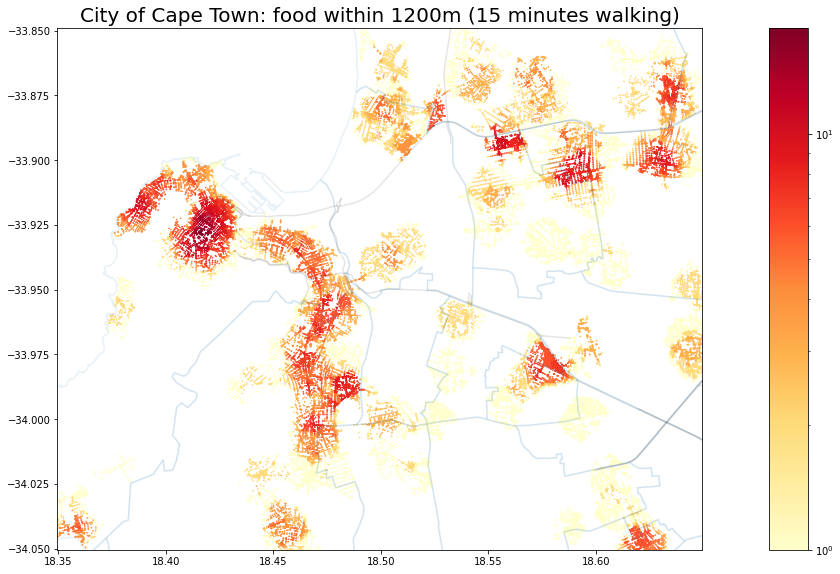

In [11]:
plot_nearest_amenity('food', 1200)

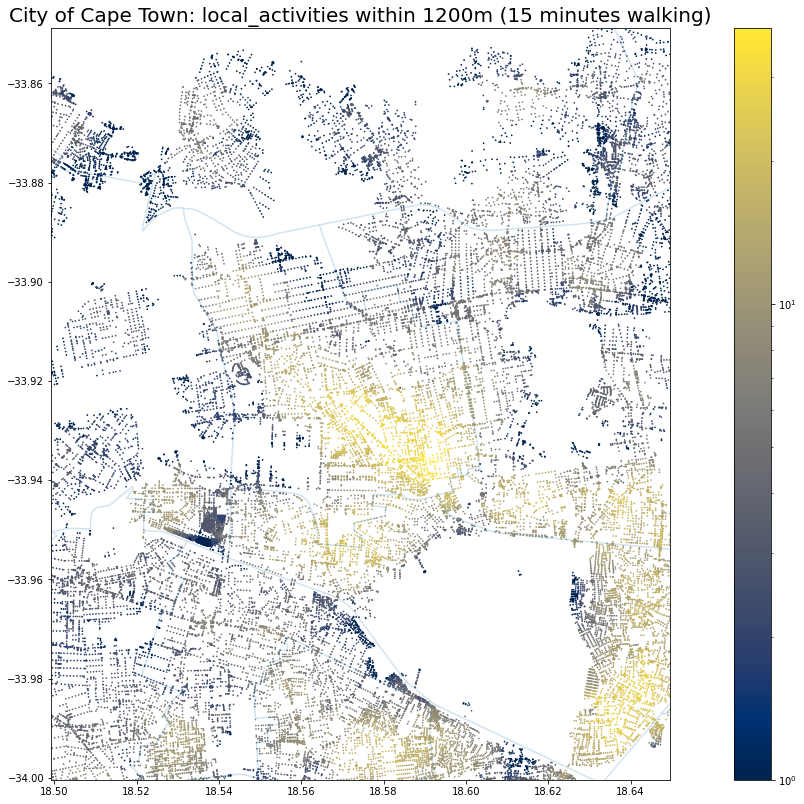

In [13]:
plot_nearest_amenity('local_activities', 1200, north_east, cmap='cividis')

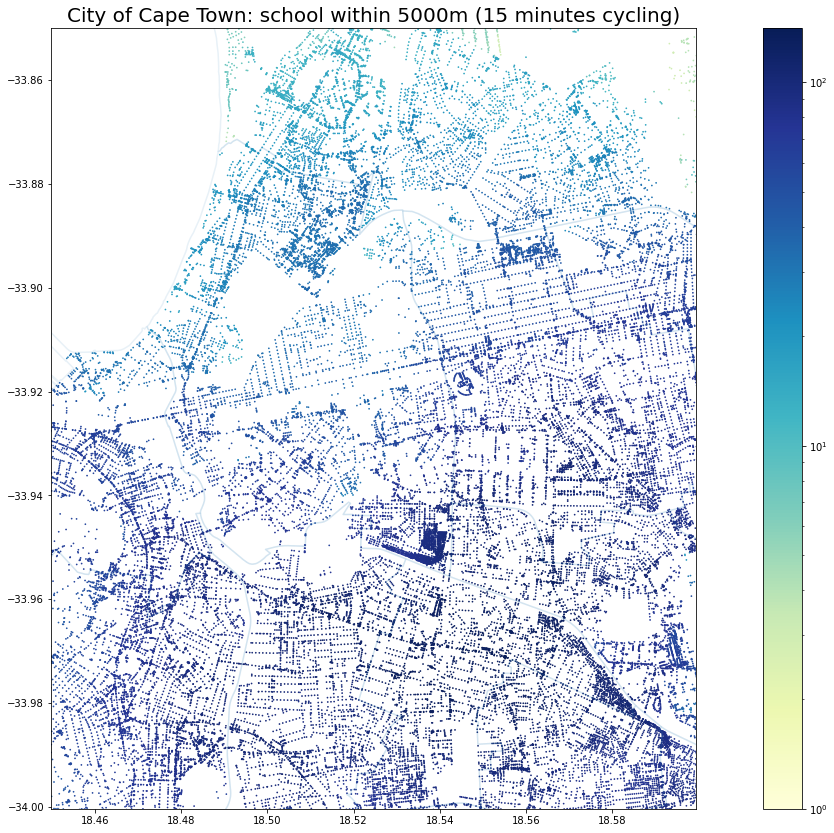

In [15]:
plot_nearest_amenity('school', 5000, central, cmap='YlGnBu')

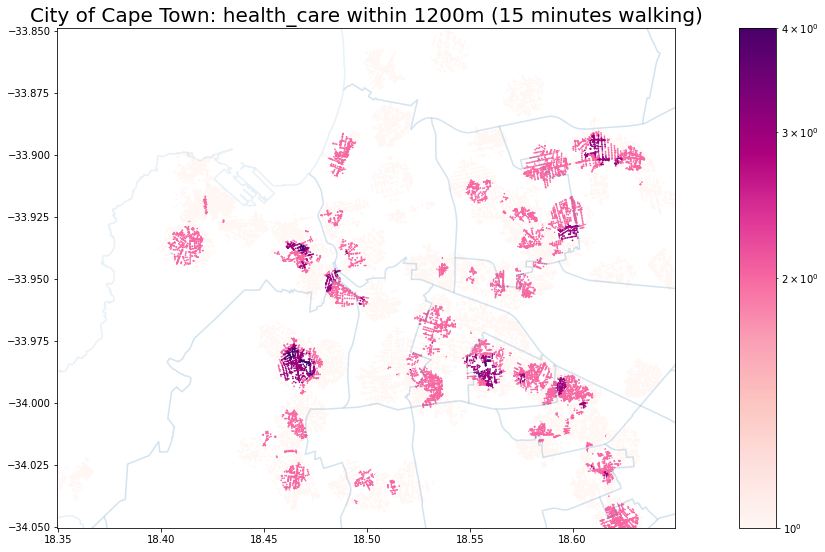

In [18]:
plot_nearest_amenity('health_care', 1200, zoom=full, cmap='RdPu')

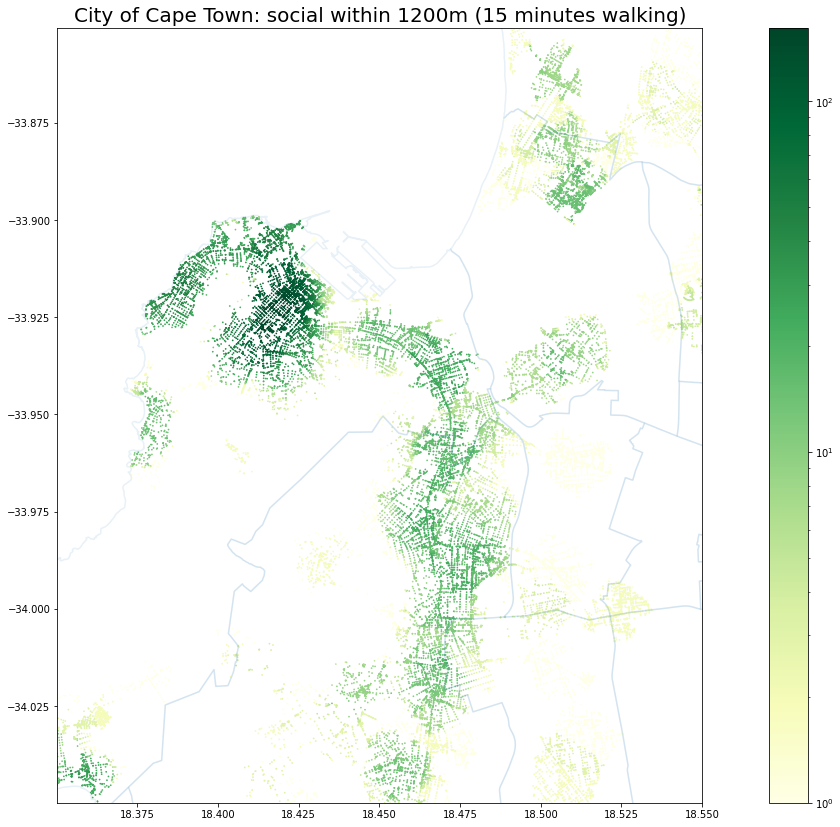

In [19]:
plot_nearest_amenity('social', 1200, west, 'YlGn')

<div class="alert alert-block alert-info"><b>
</b>
    
**DataFrames can be built similar to notebook 02_Employment_and_Labour.**
</div>